In [1]:
import datetime
from collections import Counter

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import seaborn as sb
sb.set(style="darkgrid")

import matplotlib.pyplot as plt
% matplotlib inline

random_seed = 42

In [2]:
data = pd.read_csv('../data/2/tula_yarobl_finished.csv', converters={'okpd': str})
data.drop(['Unnamed: 0'], inplace=True, axis=1)
data.drop(data[data.exec_date == -1].index, inplace=True)
print(data.shape)
data.head(5)

(37995, 26)


,cntrID,org_cntr_num,org_1s_sev,org_1s_sup_sev,sup_cntr_num,sup_cntr_avg_price,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,sup_1s_sev,...,price_higher_pmp,price_too_low,price,pmp,okpd,type_prod,cntr_lvl,sign_date,exec_date,cntr_result
0,480853,177,0.0,0.0,292,51386,0.0,1.0,1.0,0,...,0,0,15985.44,15985.44,0,19,3,20150112,20150331,0
1,480867,431,0.0,0.0,6,171863,0.0,1.0,1.0,0,...,0,0,98355.00,98850.00,0,19,3,20150110,20151231,0
2,481366,621,0.0,0.0,287,215299,0.0,1.0,1.0,0,...,0,0,82724.30,83140.00,0,19,2,20150112,20151231,0
3,481425,773,0.0,0.0,1,90000,0.0,1.0,1.0,0,...,0,0,90000.00,90000.00,0,19,2,20150112,20151231,0
4,481812,76,0.0,0.0,365,201042,0.0,1.0,1.0,0,...,0,0,107440.10,107980.00,0,19,2,20150114,20150430,0


In [3]:
num_var = [
    'org_cntr_num', 'sup_cntr_num', 
    'sup_cntr_avg_price', 
    'price', 'pmp'
]
num_var01 = [
    'org_1s_sev', 'org_1s_sup_sev', 'sup_cntr_avg_penalty',
    'sup_no_pnl_share', 'sup_okpd_exp', 
    'sup_1s_sev', 'sup_1s_org_sev',
    'sup_sim_price'
]
cat_var = [
    'sup_type', 'sup_status', 'org_form', 'org_type',
    'okpd', 'type_prod', 'cntr_lvl'
]
cat_bin_var = [
    'price_higher_pmp', 'price_too_low'
]

### Анализ количественных переменных

In [4]:
data[num_var].describe()

,org_cntr_num,sup_cntr_num,sup_cntr_avg_price,price,pmp
count,37995.000000,37995.000000,3.799500e+04,3.799500e+04,3.799500e+04
mean,551.794131,2011.477642,6.029066e+05,7.089874e+05,7.679358e+05
std,746.578061,3014.824151,9.374485e+06,9.520871e+06,9.810846e+06
min,1.000000,1.000000,0.000000e+00,1.000000e-02,0.000000e+00
25%,112.000000,11.000000,8.526750e+04,3.353624e+04,3.640300e+04
50%,251.000000,164.000000,1.447320e+05,9.840031e+04,1.080526e+05
75%,756.000000,4307.000000,2.862330e+05,3.266715e+05,3.697000e+05
max,6408.000000,7651.000000,1.151663e+09,1.151663e+09,1.205930e+09


In [5]:
# Мода
for nv in num_var:
    print('{}: {}'.format(nv, data[nv].mode()[0]))

org_cntr_num: 260
sup_cntr_num: 7651
sup_cntr_avg_price: 144732
price: 4594368.88
pmp: 0.0


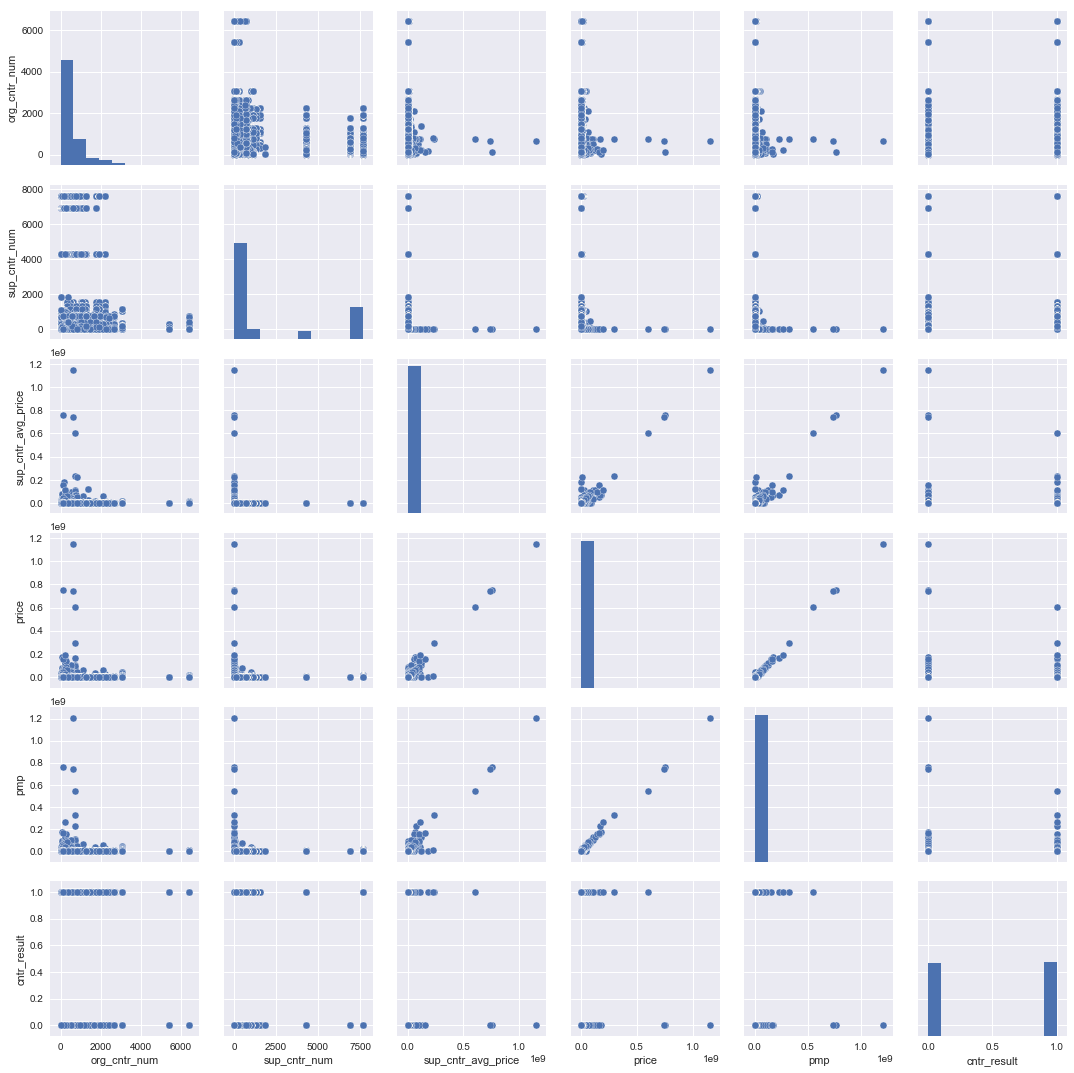

In [6]:
num_var_cntr = list(num_var)
num_var_cntr.append('cntr_result')
sb.pairplot(data[num_var_cntr])

In [7]:
data[num_var_cntr].corr()

,org_cntr_num,sup_cntr_num,sup_cntr_avg_price,price,pmp,cntr_result
org_cntr_num,1.000000,-0.257627,0.010299,0.006476,0.006723,0.287530
sup_cntr_num,-0.257627,1.000000,-0.033001,-0.010207,-0.011185,-0.494350
sup_cntr_avg_price,0.010299,-0.033001,1.000000,0.957858,0.951695,0.003425
price,0.006476,-0.010207,0.957858,1.000000,0.996922,-0.009541
pmp,0.006723,-0.011185,0.951695,0.996922,1.000000,-0.009955
cntr_result,0.287530,-0.494350,0.003425,-0.009541,-0.009955,1.000000


**Вывод.** 
Имеет смысл прологарифмировать все количественные переменные, так как они имеют большой правый хвост.
Признаки org_cntr_num и sup_cntr_num являются важными, так как имеют большую корреляцию с результатом.
Корреляция между pmp, price и sup_cntr_avg_price очень велика, необходимо избавиться от сильно линейно коррелирующих друг с другом переменных.

In [8]:
df = data.copy()

# Логарифмирование всех количественных переменных
for nv in num_var:
    df.loc[df[nv]==0, nv] = 1
    df[nv] = np.log(df[nv])

df[num_var].describe()

,org_cntr_num,sup_cntr_num,sup_cntr_avg_price,price,pmp
count,37995.000000,37995.000000,37995.000000,37995.000000,37995.000000
mean,5.570946,4.991104,12.028612,11.549245,11.430021
std,1.299925,3.042495,1.104602,1.766272,2.507489
min,0.000000,0.000000,0.000000,-4.605170,0.000000
25%,4.718499,2.397895,11.353548,10.420382,10.502406
50%,5.525453,5.099866,11.882639,11.496799,11.590373
75%,6.628041,8.367997,12.564561,12.696710,12.820447
max,8.765302,8.942592,20.864473,20.864473,20.910517


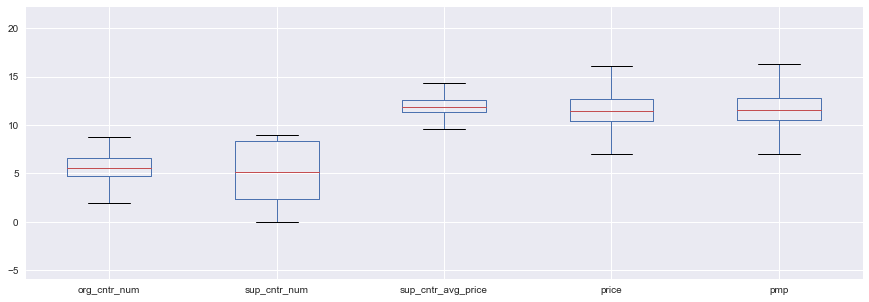

In [9]:
fig = plt.figure(figsize = (15,5))
ax = fig.gca()
df[num_var].boxplot(ax=ax)

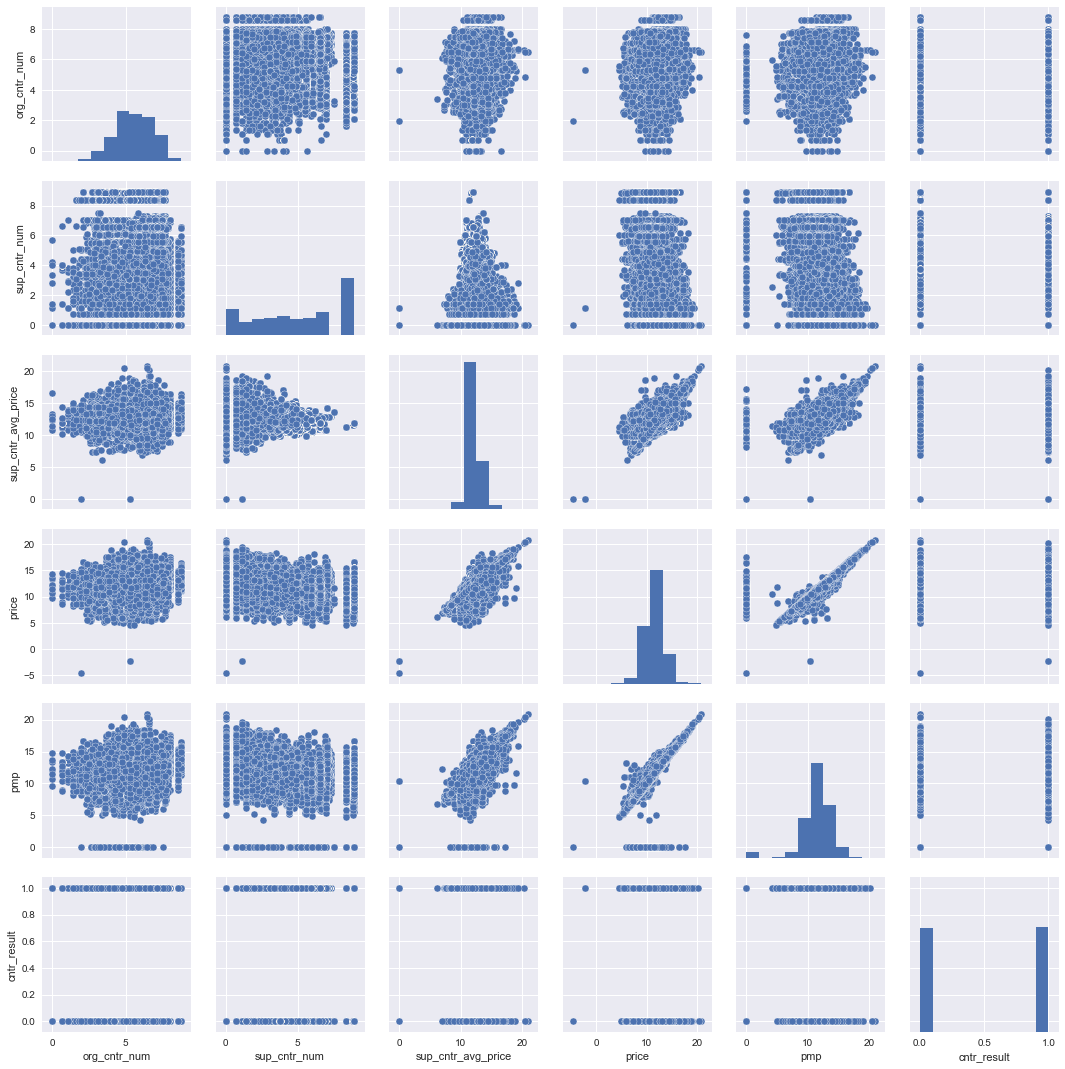

In [10]:
sb.pairplot(df[num_var_cntr])

### Анализ количественных переменных, принимающих значения [0, 1]

In [11]:
data[num_var01].describe()

,org_1s_sev,org_1s_sup_sev,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,sup_1s_sev,sup_1s_org_sev,sup_sim_price
count,37995.000000,37995.000000,37995.000000,37995.000000,37995.000000,37995.0,37995.000000,37995.000000
mean,0.000182,0.000044,0.000033,0.999739,0.571284,0.0,0.000007,0.223457
std,0.002946,0.001039,0.001411,0.006085,0.433296,0.0,0.000723,0.285493
min,0.000000,0.000000,0.000000,0.400000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.056860,0.0,0.000000,0.066425
50%,0.000000,0.000000,0.000000,1.000000,0.725000,0.0,0.000000,0.106520
75%,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.204580
max,0.111110,0.142860,0.120910,1.000000,10.000000,0.0,0.090910,1.000000


In [12]:
# Косяк в SQL-запросе на уровне сбора данных
# sup_okpd_exp не может быть больше 1
data.loc[data['sup_okpd_exp'] > 1, 'sup_okpd_exp'] = 1

In [13]:
num_var01_cntr = list(num_var01)
num_var01_cntr.append('cntr_result')
data[num_var01_cntr].corr()

,org_1s_sev,org_1s_sup_sev,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,sup_1s_sev,sup_1s_org_sev,sup_sim_price,cntr_result
org_1s_sev,1.000000,0.016905,-0.000198,-0.000898,0.038911,NaN,0.007331,0.025935,0.011652
org_1s_sup_sev,0.016905,1.000000,-0.000024,0.001080,0.018047,NaN,-0.000431,0.017824,0.021682
sup_cntr_avg_penalty,-0.000198,-0.000024,1.000000,-0.204765,-0.002321,NaN,-0.000243,-0.004436,-0.016260
sup_no_pnl_share,-0.000898,0.001080,-0.204765,1.000000,-0.001482,NaN,0.000440,0.003799,0.001954
sup_okpd_exp,0.038911,0.018047,-0.002321,-0.001482,1.000000,NaN,0.002058,0.403972,0.689781
sup_1s_sev,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sup_1s_org_sev,0.007331,-0.000431,-0.000243,0.000440,0.002058,NaN,1.000000,-0.004435,-0.003720
sup_sim_price,0.025935,0.017824,-0.004436,0.003799,0.403972,NaN,-0.004435,1.000000,0.227212
cntr_result,0.011652,0.021682,-0.016260,0.001954,0.689781,NaN,-0.003720,0.227212,1.000000


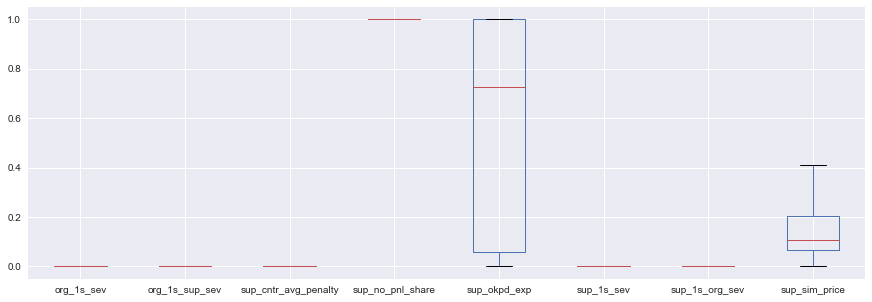

In [14]:
fig = plt.figure(figsize = (15,5))
ax = fig.gca()
data[num_var01].boxplot(ax=ax)

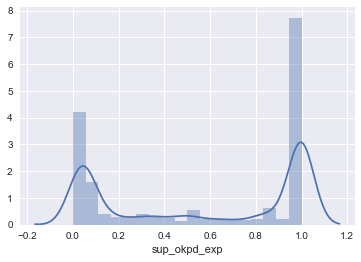

In [15]:
sb.distplot(data['sup_okpd_exp'])

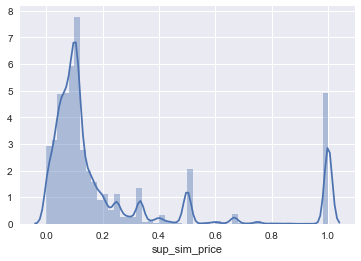

In [16]:
sb.distplot(data['sup_sim_price'])

**Вывод.** Возможно, имеет смысл удалить все переменные, кроме sup_okpd_exp и sup_sim_price

### Анализ категориальных переменных

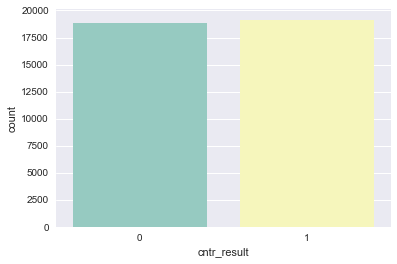

In [17]:
sb.countplot(x='cntr_result', data=data, palette='Set3')

In [18]:
for cv in cat_var:
    print('{}: {}'.format(cv, len(set(data[cv]))))

sup_type: 5
sup_status: 7
org_form: 88
org_type: 16
okpd: 1069
type_prod: 33
cntr_lvl: 4


In [19]:
def cntr_distrib_over_cat_var(cat_var, fig_width=20, percent=True):
    total, bad, good = Counter(), Counter(), Counter()
    l, t, b, g = [], [], [], []

    for row in data[[cat_var, 'cntr_result']].itertuples():
        total[row[1]] += 1
        if row[2]:
            good[row[1]] += 1
        else:
            bad[row[1]] += 1

    for val in set(data[cat_var]):
        l.append(val)
        t.append(total.get(val))
        b.append(bad.get(val, 0))
        g.append(good.get(val, 0))

    df = pd.DataFrame({cat_var: l, 'bad': b, 'good': g, 'total': t}) 
    
    r = range(len(l))
    fig = plt.figure(figsize=(fig_width,5))
    ax = plt.subplot(111)
    plt.xticks(r, l)
    plt.xlabel(cat_var)
    
    if percent:
        df['bad_p'] = df['bad'] / df['total']
        df['good_p'] = df['good'] / df['total']

        ax.bar(r, df['bad_p'], color='#FF665F', edgecolor='white', label='Плохие контракты')
        ax.bar(r, df['good_p'], bottom=df['bad_p'], color='#5FFF92', edgecolor='white', label='Хорошие контракты')
        plt.ylabel("Доля")
        plt.title("Доля плохих и хороших контрактов в зависимости от {}".format(cat_var))
    else:
        ax.bar(r, df['bad'], color='#FF665F', edgecolor='white', label='Плохие контракты')
        ax.bar(r, df['good'], bottom=df['bad'], color='#5FFF92', edgecolor='white', label='Хорошие контракты')
        plt.ylabel("Количество")
        plt.title("Количество плохих и хороших контрактов в зависимости от {}".format(cat_var))
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

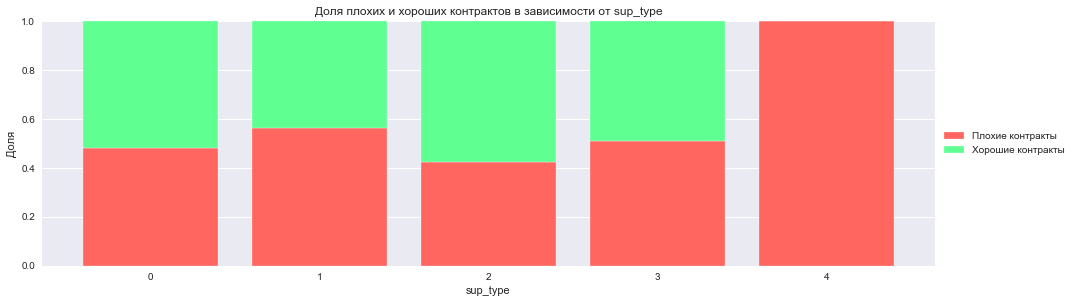

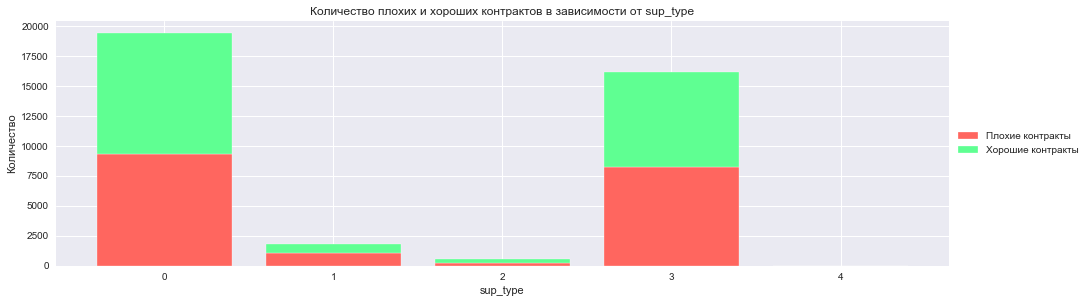

In [20]:
cntr_distrib_over_cat_var('sup_type')
cntr_distrib_over_cat_var('sup_type', percent=False)

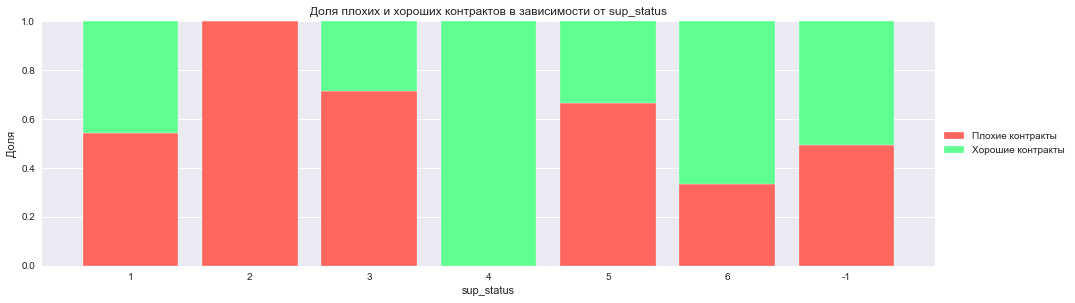

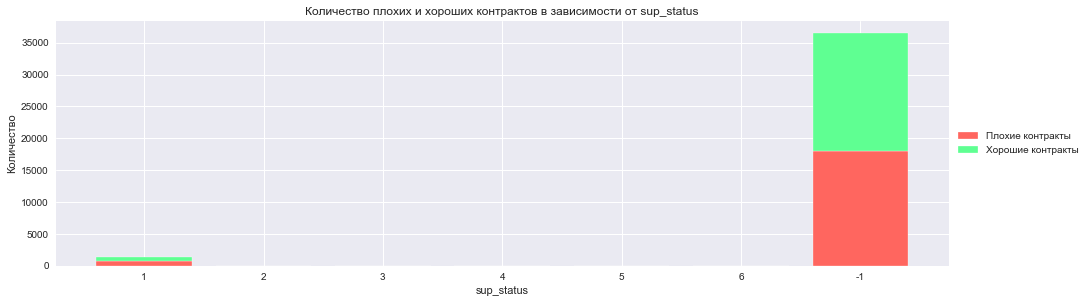

In [21]:
cntr_distrib_over_cat_var('sup_status')
cntr_distrib_over_cat_var('sup_status', percent=False)

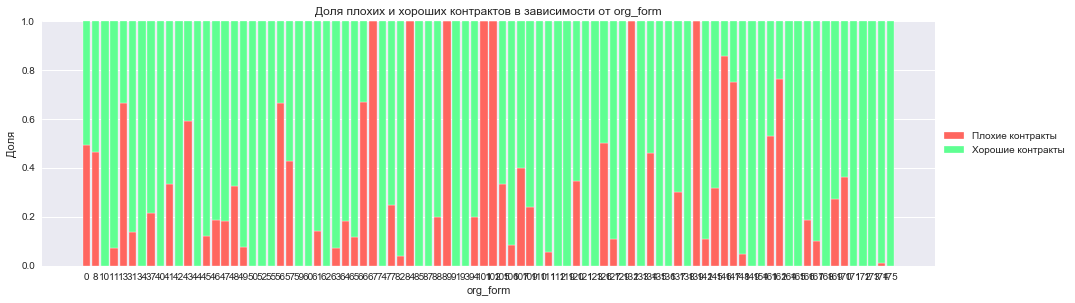

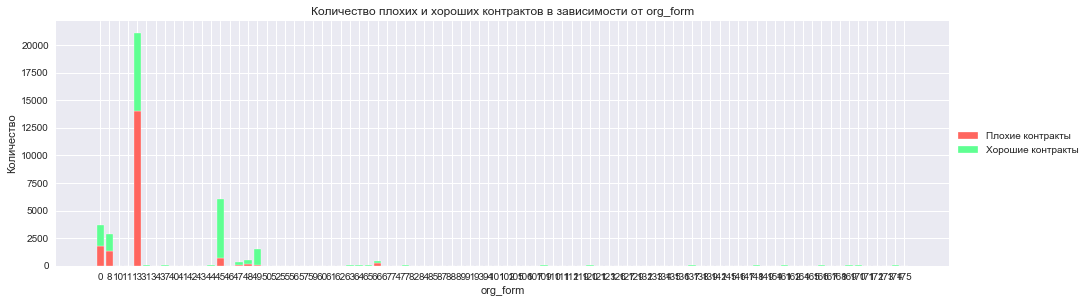

In [22]:
cntr_distrib_over_cat_var('org_form')
cntr_distrib_over_cat_var('org_form', percent=False)

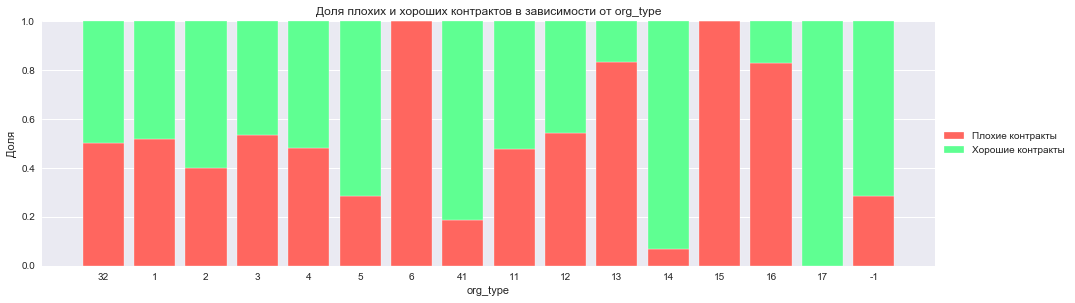

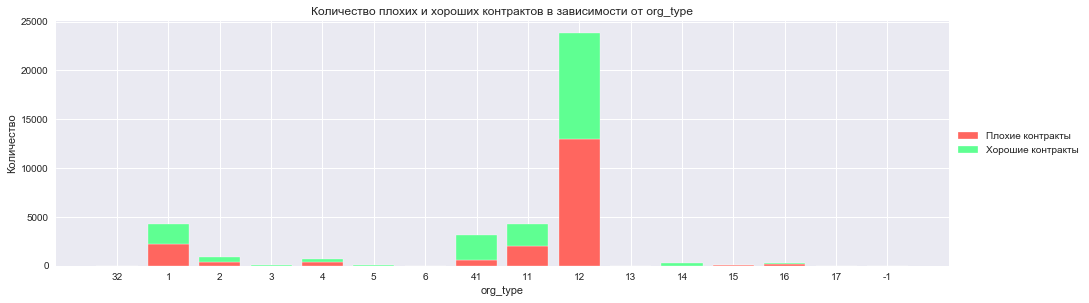

In [23]:
cntr_distrib_over_cat_var('org_type')
cntr_distrib_over_cat_var('org_type', percent=False)

В выборке больше всего контрактов от бюджетных учреждений (1, 12). За ним следуют федеральныый ОГВ (11) и органы государственной власти (41).

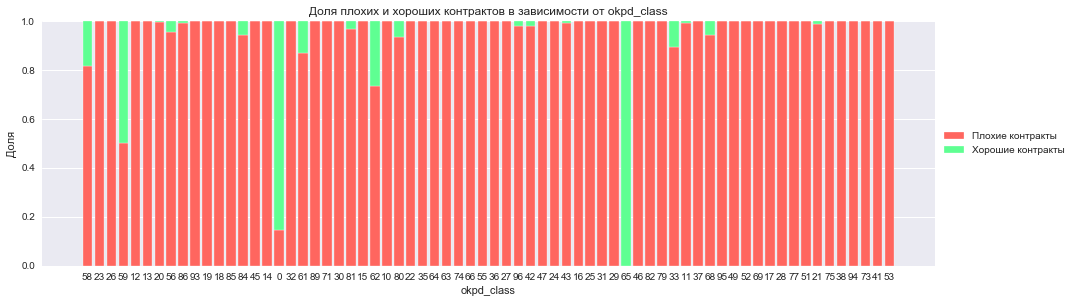

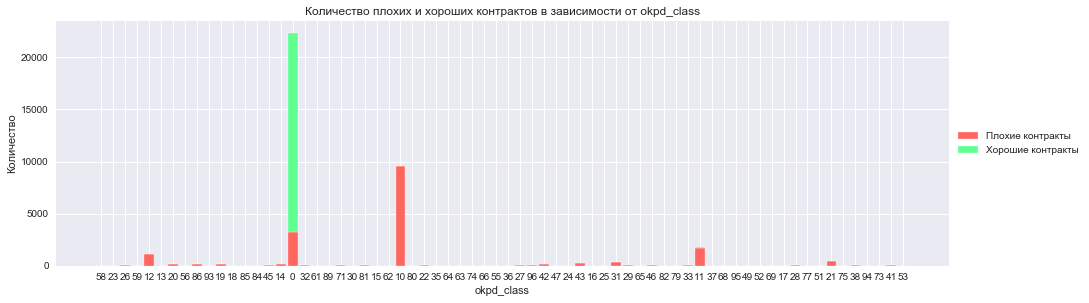

In [24]:
data['okpd_class'] = data['okpd'].apply(lambda a: pd.Series(a[:2]))

cntr_distrib_over_cat_var('okpd_class')
cntr_distrib_over_cat_var('okpd_class', percent=False)

В выборке больше всего неблагонадежных контрактов в таких сферах, как 12 (изделия табачные), 10 (продукты пищевые), 11 (напитки).

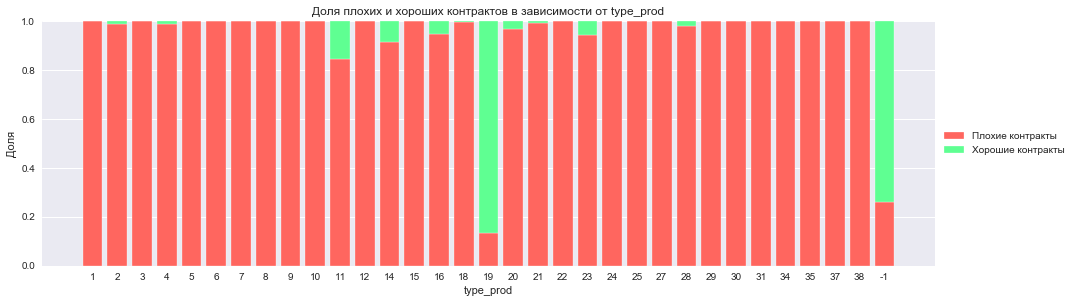

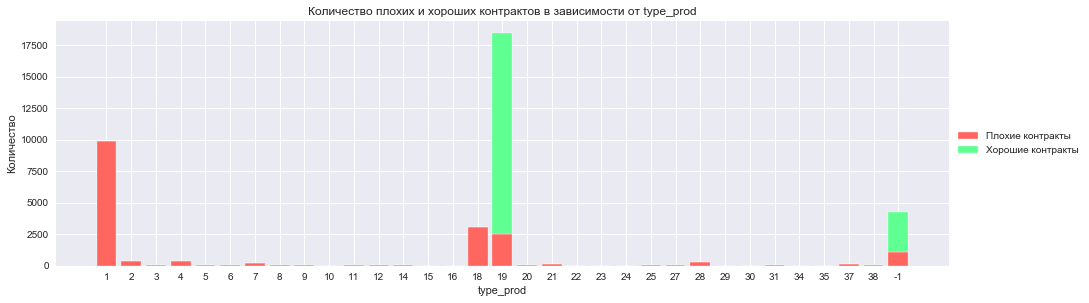

In [25]:
cntr_distrib_over_cat_var('type_prod')
cntr_distrib_over_cat_var('type_prod', percent=False)

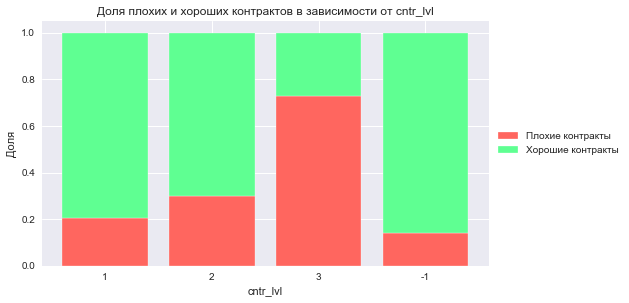

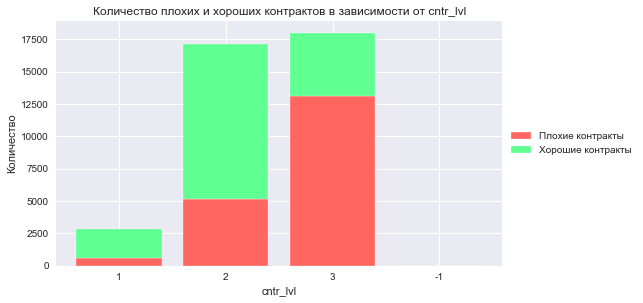

In [26]:
cntr_distrib_over_cat_var('cntr_lvl', fig_width=10)
cntr_distrib_over_cat_var('cntr_lvl', fig_width=10, percent=False)

### Анализ категориальных бинарных переменных

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a27913da0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a2763b710>]], dtype=object)

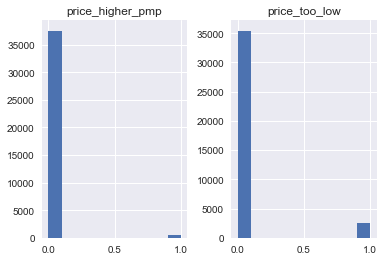

In [27]:
data[cat_bin_var].hist()

In [28]:
cat_bin_var_cntr = list(cat_bin_var)
cat_bin_var_cntr.append('cntr_result')
data[cat_bin_var_cntr].corr()

,price_higher_pmp,price_too_low,cntr_result
price_higher_pmp,1.00000,-0.030710,0.030970
price_too_low,-0.03071,1.000000,0.116376
cntr_result,0.03097,0.116376,1.000000


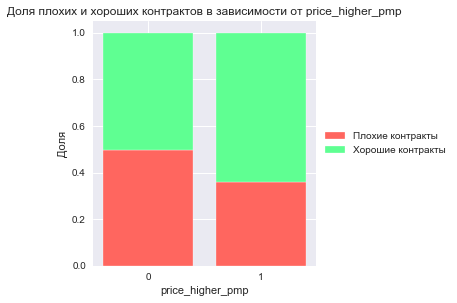

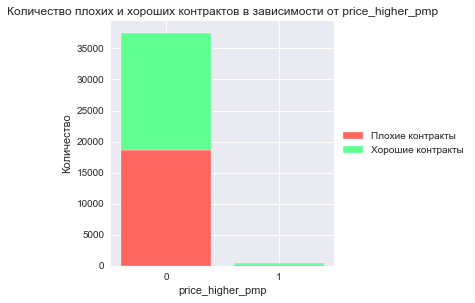

In [29]:
cntr_distrib_over_cat_var('price_higher_pmp', fig_width=5)
cntr_distrib_over_cat_var('price_higher_pmp', fig_width=5, percent=False)

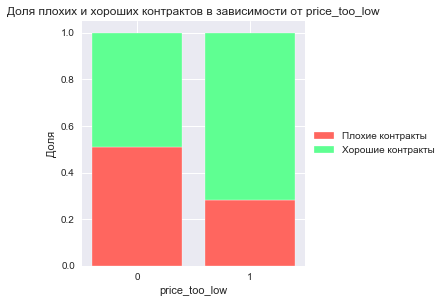

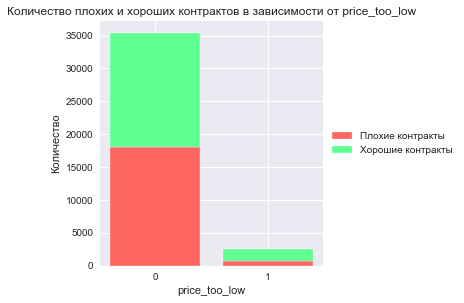

In [30]:
cntr_distrib_over_cat_var('price_too_low', fig_width=5)
cntr_distrib_over_cat_var('price_too_low', fig_width=5, percent=False)

**Выводы.** Во-первых, очень редко наблюдаются случаи, когда цена выше МНЦК (price_higher_pmp). Во-вторых, в случае когда этот критерий срабатывает доля хороших контрактов не уменьшается, а наоборот увеличивается. Аналогичные размышления верны для переменной price_too_low.

### Выбор признаков

In [31]:
cntr_start = data['sign_date'].apply(lambda a: pd.Series(datetime.datetime.strptime(str(a), "%Y%m%d").date()))
cntr_end = data['exec_date'].apply(lambda a: pd.Series(datetime.datetime.strptime(str(a), "%Y%m%d").date()))

data['cntr_length'] = (cntr_end - cntr_start)[0].apply(lambda a: pd.Series(int(str(a).split()[0])))
data.drop(data[data.cntr_length == 0].index, inplace=True)

In [32]:
X = data.drop(['cntrID', 'cntr_result', 'okpd', 'sign_date', 'exec_date', 'sup_status'], axis=1)
columns = X.columns

X.loc[X.sup_type == 0, 'sup_type'] = 3
X.loc[(X.org_form == 45) | (X.org_form == 0), 'org_form'] = 13
X.loc[(X.org_type == 1) | (X.org_type == -1), 'org_type'] = 12
X.loc[X.type_prod == -1, 'type_prod'] = 19
X.loc[X.cntr_lvl == -1, 'cntr_lvl'] = 3

y = data.cntr_result.values

In [33]:
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X.values, y)
result = sorted(
    dict(zip(columns, [e for e in list(fit.scores_)])).items(),
    key=lambda a: a[1],
    reverse=True
)

In [34]:
result

[('sup_1s_sev', nan),
 ('pmp', 474517248.60944879),
 ('price', 444336906.73920524),
 ('sup_cntr_avg_price', 65182150.405736923),
 ('sup_cntr_num', 41762958.00630077),
 ('org_cntr_num', 3180156.3817934003),
 ('okpd_class', 240468.53156671108),
 ('type_prod', 68954.362990681344),
 ('org_form', 20769.521484021174),
 ('sup_okpd_exp', 5841.3432776434511),
 ('org_type', 5696.4803629836597),
 ('cntr_length', 1544.9595261063314),
 ('cntr_lvl', 1093.5008400286229),
 ('sup_sim_price', 712.08610651288097),
 ('price_too_low', 479.05560607942584),
 ('price_higher_pmp', 36.338993670812798),
 ('sup_type', 1.4642296209073749),
 ('sup_cntr_avg_penalty', 0.59637291011338822),
 ('org_1s_sup_sev', 0.44037283422942197),
 ('org_1s_sev', 0.24522097826798953),
 ('sup_1s_org_sev', 0.036770121457425482),
 ('sup_no_pnl_share', 5.1410520815779136e-06)]